In [1]:
import keras
import numpy as np
import time
from keras import backend as k
from keras import optimizers
from keras.layers import *
from keras.models import Model
#from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras.engine.topology import Layer
from keras.datasets import mnist
from keras.losses import binary_crossentropy, mean_squared_error
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from google.colab import files
from scipy.stats import norm

Using TensorFlow backend.


In [0]:
batchsize = 128
n_z = 2

This is the sample function needed to combine the encoder and decoder model.

Task: (20 points)

- Implement the reparameterziation trick for sampling latents. (10 points)
- Explain why we need to use this trick. (10 points)

In [0]:
def sample_z(args):
    mu, log_sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

**Explain why we need to use this trick:**

To train the model, we need the gradient of the sampling operation, but without the reparametrization trick, this samping operation is not differentiable. This trick takes the part that is not differentiable out of the network which enables us to train the network.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
batches = int(len(x_train)/batchsize)

In [0]:
image_size = x_train.shape[1]

In [0]:
#x_train1 = x_train[:20000]
#batches = int(len(x_train1)/batchsize)

In [0]:
x_val = np.reshape(x_test[:5000], (x_test[:5000].shape[0], 28, 28, 1))
x_test1 = x_test[5000:]
x_test2 = np.reshape(x_test[5000:], (x_test[5000:].shape[0], 28, 28, 1))

In [0]:
def batch_generator():
    
    while True:

        for batch in range(batches):
            x = []
            
            data = x_train[batch * batchsize: (batch + 1) * batchsize]
            for i in data:
                x.append(np.reshape(i, (28, 28, 1)))
            
            x_train2 = np.asarray(x)
            yield (x_train2, x_train2) # the data is also the target (since we're re-generating images)

This is the code for the encoder. It transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables.

Task: (10 points)

- Implement the encoder class for a variational autoencoder. Note that the encoder should output the Gaussian distribution parameters (mean and variance per feature) of features rather than features themselves.

In [0]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [0]:
inputs1 = Input(shape = (28, 28, 1))

encode = Conv2D(64, (2, 2), strides=2, padding = 'same')(inputs1)

encode = Activation('relu')(encode)

encode = BatchNormalization(axis = -1, scale=None)(encode)

encode = Conv2D(64, (2, 2), strides=2, padding = 'same')(encode)

encode = Activation('relu')(encode)

encode = BatchNormalization(axis = -1, scale=None)(encode)

out_shape = list(k.int_shape(encode))

encode = Flatten()(encode)

encode = Dense(1024, activation = 'relu')(encode)

encode = Dropout(0.5)(encode)

mu = Dense(n_z, activation = 'linear')(encode)

log_sigma = Dense(n_z, activation = 'linear')(encode)


mu, log_sigma = KLDivergenceLayer()([mu, log_sigma])
z_sigma = Lambda(lambda t: K.exp(.5*t))(log_sigma)

eps = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], n_z)))
z_eps = Multiply()([z_sigma, eps])
latent_vector = Add()([mu, z_eps])

#latent_vector = Lambda(sample_z, output_shape=(n_z,))([mu, log_sigma])



model_encoder = Model(inputs = [inputs1, eps], outputs = latent_vector)

In [11]:
model_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   320         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 14, 14, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 64)   192         activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

This is the code for the decoder. It transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and z is latents.

Task: (10 points)

- Implement the decoder class for a variational autoencoder. Note that the decoder should output the Gaussian distribution parameters (mean and variance per pixel) of images rather than images themselves.

In [0]:
inputs2 = Input(shape = (n_z,))

decode = Dense(out_shape[1] * out_shape[2] * out_shape[3], activation = 'relu')(inputs2)

decode = Reshape((out_shape[1], out_shape[2], out_shape[3]))(decode)

decode = Conv2DTranspose(64, (2, 2), strides=2, padding = 'same')(decode)

decode = Activation('relu')(decode)

decode = BatchNormalization(axis = -1, scale=None)(decode)

decode = Conv2DTranspose(64, (2, 2), strides=2, padding = 'same')(decode)

decode = Activation('relu')(decode)

decode = BatchNormalization(axis = -1, scale=None)(decode)

out = Conv2DTranspose(1, (2, 2), activation = 'sigmoid', padding = 'same')(decode)

model_decoder = Model(inputs = inputs2, outputs = out)

In [13]:
model_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        16448     
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        192       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        16448     
__________

In [0]:
outputs = model_decoder(model_encoder([inputs1, eps]))
model = Model([inputs1, eps], outputs)

This is the loss class. The loss of encoder and decoder of a variational autoencoder is the evidence lower bound as follows:

$L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

The first term above is the KL divergence between the approximate posterior (q) and the prior (p), which can be interpreted as a form of regularization. You can assume that the prior is unit Gaussian. It can be implemented with the F.gaussian_kl_divergence function in Chainer.

The second term above is the Gaussian negative log likelihood. This is the term that fits the data, which is very similar to the usual loss functions that you use in deep learning. It can be implemented with the F.gaussian_nll function in Chainer.

Task: 

- Implement the loss class. (10 points)
- Explain why we use log variance instead of variance. (5 points)



In [0]:
def nll_(y_true, y_pred):
  
    likelihood = K.tf.distributions.Normal(loc = k.mean(y_pred), scale = k.std(y_pred))

    return - K.sum(likelihood.log_prob(y_true), axis=-1)

In [0]:
def _loss(y_true, y_pred):
    nll_loss = nll_(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = -0.5 * K.sum(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis=-1)
    vae_loss = kl_loss - nll_loss
    
    return vae_loss

**Explain why we use log variance instead of variance:**

Why use log variance instead of variance: Because taking the exponent is numerically more stable than taking the log.


In [0]:
adam_ = optimizers.Adam(lr = 1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-9)

In [0]:
#rmsprop_ = optimizers.rmsprop(lr = 1e-4)

In [0]:
model.compile(optimizer = adam_, loss = nll_)

In [0]:

#checkpointer = ModelCheckpoint(filepath='checkpoint_vae.h5', save_best_only=True)

In [0]:
#tensorboard = TensorBoard(log_dir="./vae_logs/{}", histogram_freq = 1, write_graph=True, 
 #                         write_images = True)

In [0]:
#callback_list = [tensorboard, checkpointer]

In [0]:
model.fit_generator(batch_generator(), steps_per_epoch = batches, epochs = 10, shuffle = True, 
                    validation_data = (x_val, x_val))

Epoch 1/10
 11/468 [..............................] - ETA: 9:11 - loss: 79462.1960

In [0]:
model.save('vae.h5')

In [0]:
model_encoder.save('encoder.h5')

In [0]:
model_decoder.save('decoder.h5')

In [27]:
#model = load_model('vae.h5', custom_objects = {'_loss': _loss})
files.download('vae.h5')



----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 59710, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
files.download('encoder.h5')

In [0]:
files.download('decoder.h5')

Task: (50 points)

- Train the above defined variational autoencoder on the Mnist dataset. You can refer to the earlier assignments to implement your training loop. (25 points)

- How good are the samples? Randomy sample some digits and visualize them. (10 points)

- How good are the reconstructions? Draw an Mnist like digit, encode it, decode it and visualize the digits. How different is the reconstruction from the original? (10 points)

- Repeat the last task but by drawing something other than a digit (e.g., a face). How accuracte is the reconstructions? Explain the results. (5 points)

** How good are the samples? Randomy sample some digits and visualize them. (10 points) **

As it can be seen the samples are good in a sense that you can recognize the digits displayed. However the overall quality of the samples can still be argued to be quite bad, since the images are very pixelated.

(60000, 28, 28)


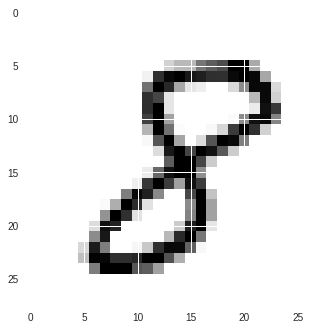

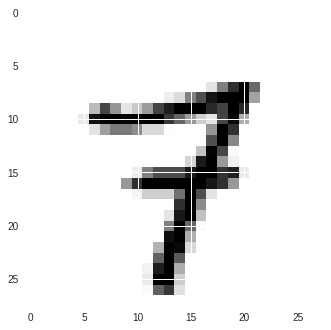

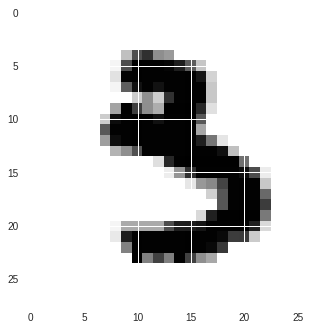

In [30]:
print(x_train.shape)

for i in range(0, 3):
    random_number = np.random.randint(0, x_train.shape[0])
    imshow(x_train[random_number, :, :], cmap=cm.binary)
    plt.show()

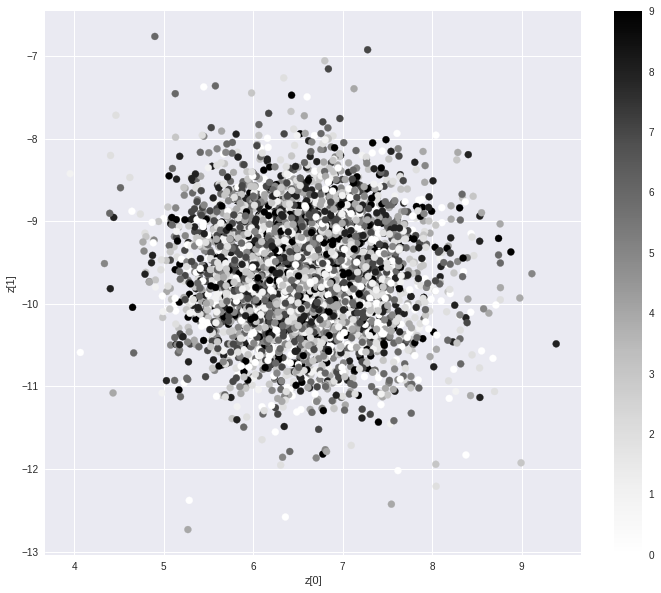

In [39]:
z_mean, _, _ = model_encoder.predict(x_test2, batch_size=batchsize)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test[5000:])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
#plt.savefig(filename)
plt.show()

In [0]:
'''n = 5
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = model_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit'''

In [0]:
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = model_decoder.predict(z_grid.reshape(n*n, n_z)).reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()

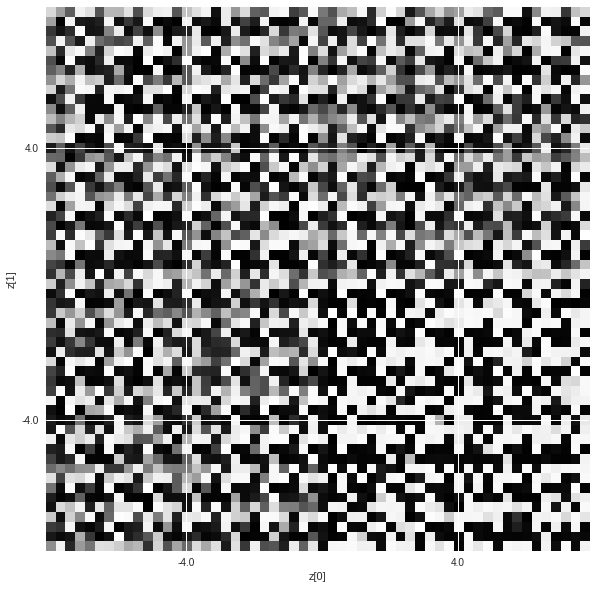

In [38]:
plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
#plt.savefig(filename)
plt.show()